In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import VotingClassifier


import utils
import pycountry

# Download NLTK resources
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Set seaborn style
sns.set(style="darkgrid")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Load the dataset
data = pd.read_csv('tumblr_posts_last.csv')
data.head()

,Unnamed: 0,Author,Paragraphs
0,0,hellyeahdragonage,"[""me: I hope the pandemic doesn't last long"", ..."
1,1,faronmckenzie,[]
2,2,fullhalalalchemist,['if you are enrolled at least half time in co...
3,3,forgotn1,['Republicans in the Senate refuse to make any...
4,4,eekahchu,[]


In [3]:
data.shape

(747, 3)

In [4]:
# Check for missing values
data.isnull().sum()


Unnamed: 0    0
Author        0
Paragraphs    0
dtype: int64

In [5]:
# Removing duplicates
print("Initial number of rows:", len(data))
data.drop_duplicates(inplace=True)
print("Number of rows after removing duplicates:", len(data))

Initial number of rows: 747
Number of rows after removing duplicates: 747


In [6]:
# Function to clean text data
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Convert to lowercase
    text = text.lower()

    return text

# Apply cleaning function to 'text' column
data['cleaned_Paragraphs'] = data['Paragraphs'].apply(clean_text)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


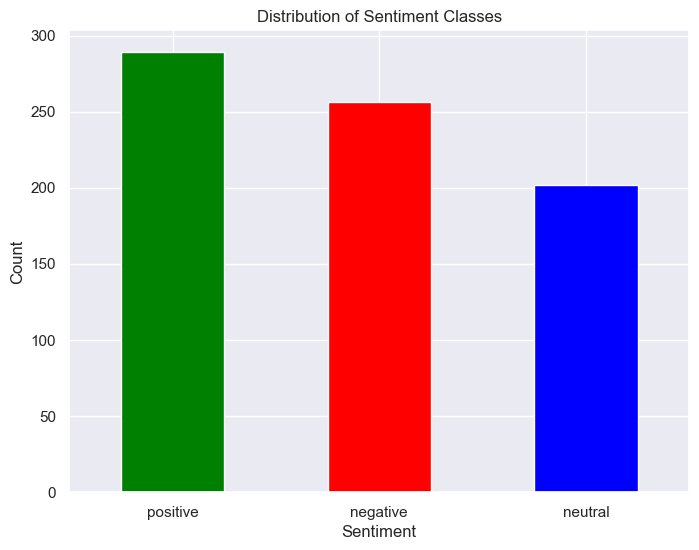

In [7]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Function to get sentiment polarity
def get_sentiment(text):
    sentiment_score = sid.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        return 'positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to 'cleaned_text' column and create a new 'sentiment' column
data['sentiment'] = data['cleaned_Paragraphs'].apply(get_sentiment)

# Count the occurrences of each sentiment class
sentiment_counts = data['sentiment'].value_counts()

# Plotting the distribution of sentiment classes
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

data["encoded_sentiment"] = label_encoder.fit_transform(data["sentiment"])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data["cleaned_Paragraphs"], data["encoded_sentiment"], test_size=0.2, random_state=42)

# TF-IDF vectorization
vectorization = TfidfVectorizer()
X_train_tfidf = vectorization.fit_transform(X_train)
X_test_tfidf = vectorization.transform(X_test)

In [13]:

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_tfidf, y_train)



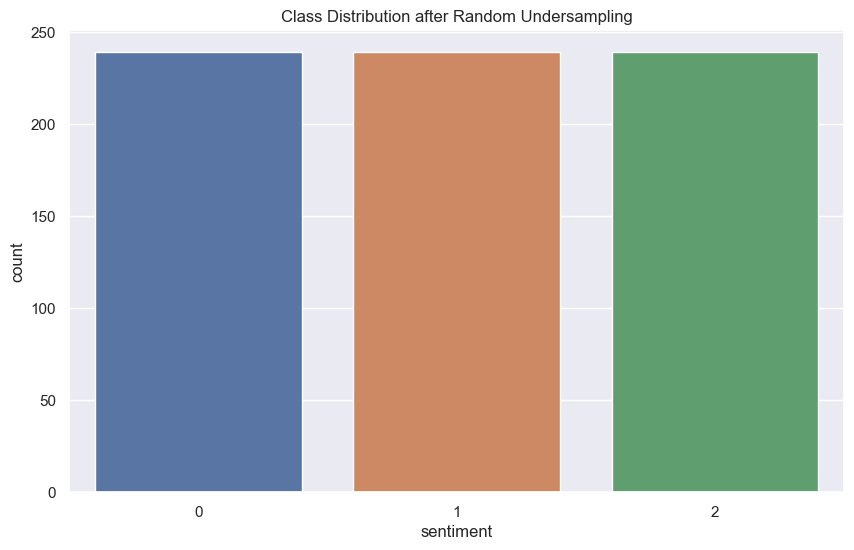

In [14]:
df_resampled = pd.DataFrame.sparse.from_spmatrix(X_train_resampled, columns=vectorization.get_feature_names_out())

df_resampled['sentiment'] = y_train_resampled

# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df_resampled)
plt.title('Class Distribution after Random Undersampling')
plt.show()

# MODELS

In [16]:
# naive_bayes

nb_classifier = MultinomialNB(alpha=0.1)

# Train the model with the resampled data
nb_classifier.fit(X_train_resampled, y_train_resampled)

cv_scores = cross_val_score(nb_classifier, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy', n_jobs=-1)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# Make predictions
y_pred = nb_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Evaluate the model
print(classification_report(y_test, y_pred))

Cross-Validation Scores: [0.59027778 0.65972222 0.59440559 0.65034965 0.86013986]
Mean CV Accuracy: 0.670979020979021
Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.59      0.77      0.67        66
           1       0.67      0.35      0.46        34
           2       0.59      0.54      0.56        50

    accuracy                           0.60       150
   macro avg       0.62      0.56      0.57       150
weighted avg       0.61      0.60      0.59       150



In [13]:
cv_scores = cross_val_score(nb_classifier, X_train_resampled, y_train_resampled, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy: {:.2f}".format(cv_scores.mean()))

Cross-Validation Scores: [0.59027778 0.65972222 0.59440559 0.65034965 0.86013986]
Mean Accuracy: 0.67


In [14]:
# decision tree classifier 


# Create a decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model on the training set
dt_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Additional metrics for classification
print(classification_report(y_test, y_pred))



Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.53      0.36      0.43        66
           1       0.58      0.65      0.61        34
           2       0.43      0.58      0.50        50

    accuracy                           0.50       150
   macro avg       0.52      0.53      0.51       150
weighted avg       0.51      0.50      0.49       150



In [15]:
# decision tree classifier cross_val

cv_scores = cross_val_score(dt_classifier, X_train_resampled, y_train_resampled, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy: {:.2f}".format(cv_scores.mean()))


Cross-Validation Scores: [0.63194444 0.61805556 0.59440559 0.64335664 0.83916084]
Mean Accuracy: 0.67


In [16]:
# Create a logistic regression model_LR

model_LR = LogisticRegression(C=5,max_iter=1000)

# Train the model_LR on the training set
model_LR.fit(X_train_resampled, y_train_resampled)



# Make predictions on the test set
y_pred = model_LR.predict(X_test_tfidf)

# Evaluate the model_LR
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.6533333333333333


In [17]:
cv_scores = cross_val_score(model_LR, X_train_resampled, y_train_resampled, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy: {:.2f}".format(cv_scores.mean()))

Cross-Validation Scores: [0.67361111 0.75       0.67132867 0.70629371 0.85314685]
Mean Accuracy: 0.73


In [18]:
# Gradient Boosting Classifier Model

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model on the training set
gb_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = gb_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Additional metrics for classification
print(classification_report(y_test, y_pred))


Accuracy: 0.6333333333333333
              precision    recall  f1-score   support

           0       0.73      0.61      0.66        66
           1       0.60      0.79      0.68        34
           2       0.56      0.56      0.56        50

    accuracy                           0.63       150
   macro avg       0.63      0.65      0.63       150
weighted avg       0.64      0.63      0.63       150



In [19]:

knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = knn_classifier.predict(X_test_tfidf)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# 3= 64

Accuracy: 0.34
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.18      0.28        66
           1       0.27      0.97      0.42        34
           2       0.86      0.12      0.21        50

    accuracy                           0.34       150
   macro avg       0.57      0.42      0.30       150
weighted avg       0.60      0.34      0.29       150



In [20]:
# Create and train a Random Forest classifier


rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = rf_classifier.predict(X_test_tfidf)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.41      0.50        66
           1       0.54      0.74      0.62        34
           2       0.38      0.46      0.41        50

    accuracy                           0.50       150
   macro avg       0.52      0.53      0.51       150
weighted avg       0.53      0.50      0.50       150



In [21]:
# Extra tree classifier 


# Create a Extra tree classifier
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)


# Train the model on the training set
extra_trees_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = extra_trees_clf.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Additional metrics for classification
print(classification_report(y_test, y_pred))

Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        66
           1       0.59      0.79      0.68        34
           2       0.49      0.66      0.56        50

    accuracy                           0.56       150
   macro avg       0.58      0.61      0.57       150
weighted avg       0.59      0.56      0.55       150



In [22]:
from sklearn.ensemble import VotingClassifier


ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_classifier),
        ('nb', nb_classifier),
        ('knn', knn_classifier),
        ('gb', gb_classifier),
        ('logreg', model_LR),
        ('dt', dt_classifier)
    ],
    voting='soft'  # Soft voting for probabilities
)

ensemble_model.fit(X_train_resampled, y_train_resampled)

y_pred = ensemble_model.predict(X_test_tfidf)


accuracy = accuracy_score(y_test, y_pred)
print(f'Ensemble Model Accuracy: {accuracy:.4f}')

Ensemble Model Accuracy: 0.5667


In [23]:
# Extra tree classifier 


# Create a Extra tree classifier
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)


# Train the model on the training set
extra_trees_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = extra_trees_clf.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Additional metrics for classification
print(classification_report(y_test, y_pred))

Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        66
           1       0.59      0.79      0.68        34
           2       0.49      0.66      0.56        50

    accuracy                           0.56       150
   macro avg       0.58      0.61      0.57       150
weighted avg       0.59      0.56      0.55       150

